# RAPID transfer Linear Regression

_Author: Aline Van Driessche_

This notebook contains all code needed to perform Linear Regression on individual latitudes (satellite observable variables available from ECCO) and RAPID information, from the in-situ array at 26.5°N. Read section headings for more details on setup, preprocessing, and model training.

# Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [207]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib
from tqdm import tqdm
import matplotlib.gridspec as gridspec

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pyplot as plt

In [2]:
# A helper function to add lags to the input (RAPID) dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [3]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [4]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [5]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [6]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [7]:
# Helper function to align the dates of RAPID inputs and ECCO data
def clip_dates(RAPID_inputs, inputs, full_outputs):

    # RAPID has the latest start date and the ECCO data has the earliest end date (combine)
    date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    #print('Date range to align to:', date_range)

    # Align the surface variable inputs with RAPID, then align the in- and outputs
    inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
    inputs, outputs = align_inputs_outputs(inputs, full_outputs, date_range = date_range, ecco=False)
    return inputs, RAPID_inputs, outputs

In [208]:
# Helper function to plot the statistics of a group of model runs (mean, 5% quantile, 95% quantile)
def retrieve_statistics(df_path):
    overview = pd.read_csv(df_path)
    mean_df = overview.groupby('Unnamed: 1').mean() 
    quantile_05_df = overview.groupby('Unnamed: 1').quantile(0.05)
    quantile_95_df = overview.groupby('Unnamed: 1').quantile(0.95)
    quantile_95_df = quantile_95_df['MAPE'].rolling(window=3, min_periods=1).mean()
    quantile_05_df = quantile_05_df['MAPE'].rolling(window=3, min_periods=1).mean()
    return mean_df, quantile_05_df, quantile_95_df

## Experiment Variables

All variables that might be worth changing during experiments.

In [86]:
# CONSTANTS
data_home = paths.LOCAL_DIR
# We are specifically interested in the atlantic mask at 30S (mass conservation from 26°N)
lat = -30           
atlantic_lon_min = -50
atlantic_lon_max = 17

cell_of_interest = "abyssal"

remove_season = False
remove_trend = False

input_vars = ['OBP', 'ZWS'] #other options are 'SSH', 'SSS', 'SST'

history_surface_vars =1
moc_rapid_timelag = 12
range_rapid_timelags = 144 #11.5 years 
repetitions_timelag = 1
intervals_timelag = 3

zonal_avg = ['time']
no_zonal_avgs = ['time', 'longitude']   #for 2D training this setting is necessary

ECCO_GRID = xr.open_dataset(paths.geom_fp)
RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
inputs_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc"
strf_30S_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"

# MISCELLANEOUS
verbose = True
mape_thresh = 0.5
cross_val_folds = 1
param_grid_levels = 2

## Loading and processing relevant data
Data loading function that extracted and preprocesses the data as defined in the “Experiment Variables” section and returns the in- and output for training. For reproduction, the RAPID streamfunction can be downloaded from the 'rapid.ac.uk' website, the satellite observable variables and the native ECCO grid from the NASA's 'PO.DAAC' website and finally the streamfunction (in depth space) at 30°S can be calculated with 'sf_sl.ipynb' (be careful to use the atlantic basin mask). 

In [87]:
# Load the input RAPID moc strength, resample to monthly mean values and calculate the timelag up to 12 years (144 months). 
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, range(range_rapid_timelags))  

In [88]:
# Load the satellite observable variables at 30°S, use the atlantic basin mask
inputs_ecco = xr.open_dataset(inputs_path).isel(latitude=slice(1,2))
inputs_ecco = inputs_ecco.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))

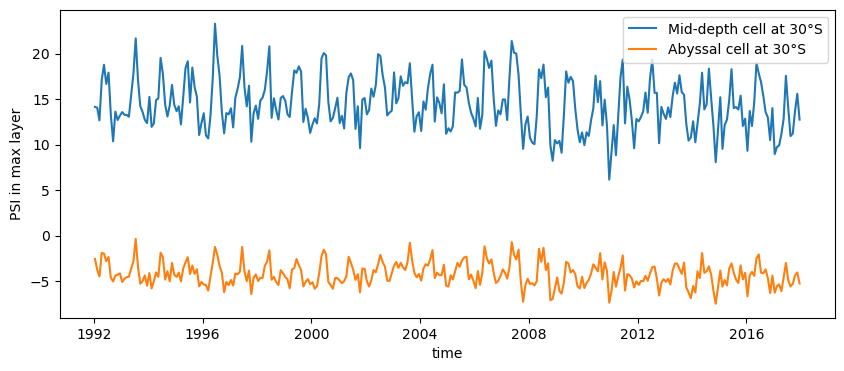

In [89]:
# Load the 30S streamfunction and calculate the moc strength in the abyssal and mid-depth cell, plot both functions. 
with open(strf_30S_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs_ecco.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

moc_30S_middepth_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
moc_30S_abyssal_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(moc_30S_middepth_cell["time"].squeeze(), moc_30S_middepth_cell["moc"].squeeze(), label='Mid-depth cell at 30°S')   
plt.plot(moc_30S_abyssal_cell["time"].squeeze(), moc_30S_abyssal_cell["moc"].squeeze(), label='Abyssal cell at 30°S') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [90]:
def retrieve_data(inputs=inputs_ecco, input_rapid=RAPID_all_inputs, output_type=cell_of_interest, history=history_surface_vars, rapid_timelag=moc_rapid_timelag, repetitions_timelag=repetitions_timelag, intervals_timelag=intervals_timelag, coords = zonal_avg, input_vars=input_vars, remove_trend=remove_trend, remove_season=remove_season, mode='combined', verbose=False):
    
    data_vars = [f"psi_moc_lag{rapid_timelag}"]
    for interval_nr in range(int(repetitions_timelag*12/intervals_timelag)):
        data_vars.append(f"psi_moc_lag{rapid_timelag+((interval_nr+1)*intervals_timelag)}")
    
    RAPID_inputs = input_rapid[data_vars]
    
    # Define which output moc we will try to predict
    if output_type == 'abyssal':
        outputs = moc_30S_abyssal_cell
    elif output_type == 'middepth':
        outputs = moc_30S_middepth_cell
    
    # Clip all the in- and outputs to the same daterange
    inputs, RAPID_inputs, outputs = clip_dates(RAPID_inputs, inputs, outputs)
    
    # Preprocess both surface variables and the RAPID input data
    pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=remove_season,
                                    remove_trend=remove_trend,
                                    standardize=True,
                                    lowpass=False)

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)

    # reshape as desired and convert to a numpy array
    pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=history, keep_coords=coords, data_vars=data_vars, verbose=False)
    pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=input_vars, verbose=False)

    # Concatenate the different information layers together
    if mode == 'RAPID':
        X = pp_data_RAPID_np
    elif mode == 'surface variables':
        X = pp_data_SURFACE_np
    elif mode == 'combined':
        X = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
    
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    y = strength_np[-X.shape[0]:]
    
    # add bias term for linear regression
    X = X.squeeze()
    X = sm.add_constant(X)
    
    if verbose is not False:
        print()
        print('Inputs shape:', X.shape)
        print('Outputs shape:', y.shape)
    return X, y

# Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. Grid search with cross-validation is performed to find the best regularization weights for ElasticNet (`alpha` and `L1_wt`); see the [`statsmodels` documentation](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html#statsmodels.regression.linear_model.OLS.fit_regularized) for more details. Our five metrics (RMSE, MAE, MAPE, $R^2$, correlation) are then calculated.

In [91]:
def perform_lr(X_train, y_train, X_test, y_test, optimal_params=None):
    
    if optimal_params is None:
        # hyperparameters to optimise
        param_grid = {
            "alpha": np.logspace(-4, 4, 10),
            "L1_wt": np.linspace(0, 1, 10)
        }

        # grid search - 10-fold cross-validation
        grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
    else:
        model = SMWrapper(**optimal_params)
        model.fit(X_train, y_train)

    #  calculate test performance and optionally report
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    metric_dict = {}
    
    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
    metric_dict['train_corr'] = round(np.corrcoef(np.array(y_pred_train).squeeze(), y_train)[0, 1], 3)
    metric_dict['test_corr'] = round(np.corrcoef(np.array(y_pred).squeeze(), y_test)[0, 1], 3)

    #  calculating custom MAPE to ignore the smallest observed MOC values
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = round(mape * 100, 3)

    if verbose:
        metrics_series = pd.Series(metric_dict)
        metrics_df = metrics_series.to_frame(name='Value')
        
    train_set_pred = model.predict(X_train)
    test_set_pred = model.predict(X_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, test_set_pred])
    }
        
    return metric_dict, predictions, model

#### Experiment 1. 
Running 1 Linear Regression with the parameters as explained in the "Experiment variables" section with n-fold cross validation.

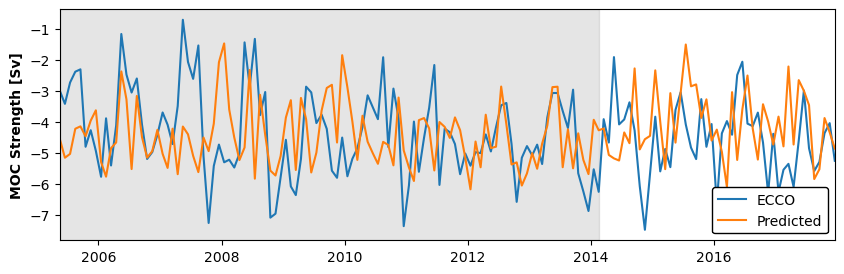

{'R^2': 0.643,
 'MSE': 0.627,
 'RMSE': 0.792,
 'MAE': 0.624,
 'MAPE': 16.984,
 'train_corr': 0.793,
 'test_corr': 0.805,
 'MAPE_thresh': 16.983}

In [108]:
X, y = retrieve_data(rapid_timelag=0, mode='combined', repetitions_timelag=1, input_vars=['ZWS'], output_type='abyssal')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=None, random_state=123456)
metric_dict, preds_dict, grid_search = perform_lr(X_train, y_train, X_test, y_test)

time = inputs_ecco.time.values[-len(X):]
fig, ax = timeseries_comparison(preds_dict['all_preds'], y, time, len(X_train))
plt.show()
metric_dict

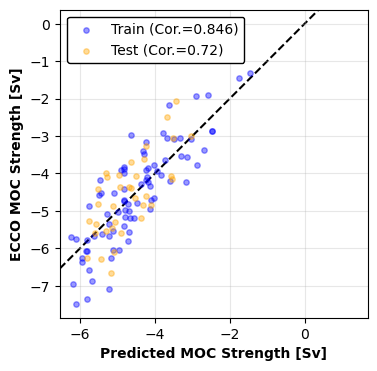

In [94]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(preds_dict['train_set_pred'], preds_dict['test_set_pred'], y_train, y_test)
plt.show()

In [126]:
metrics_models = []
predictions_models = []

for model_iteration in range(3):
    X, y = retrieve_data(rapid_timelag=12, repetitions_timelag=1, mode='combined', input_vars=['ZWS'], output_type='abyssal')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=None)
    metric_dict, preds_dict, grid_search = perform_lr(X_train, y_train, X_test, y_test)
    
    metrics_models.append(metric_dict)
    predictions_models.append(preds_dict)

metrics_df = pd.DataFrame(metrics_models)
predictions_df = pd.DataFrame(predictions_models)

summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

,mean,std
R^2,0.509,0.109
MSE,0.814,0.054
RMSE,0.902,0.030
MAE,0.709,0.029
MAPE,17.433,4.218
train_corr,0.831,0.015
test_corr,0.773,0.044
MAPE_thresh,17.433,4.218


#### Experiment 2. 

Running the same model multiple times with varying timelag from the RAPID data to assess the transfer of information over time. Example here is for the 'combined' mode, but RAPID and the surface variables can also be assessed separate.

In [96]:
optimal_params = {
    "alpha": 0.005,
    "L1_wt": 0.5
}

mode = 'RAPID'
list_metrics_dfs = []
model_iterations = 100

# To loop over several models and compare the performances
for i in tqdm(range(model_iterations)):
    metrics = []
    preds = []

    for rapid_timelag in range(108):
        X, y = retrieve_data(rapid_timelag=rapid_timelag, mode=mode, repetitions_timelag=2, input_vars=['ZWS'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=None)
        metric_dict, preds_dict, model = perform_lr(X_train, y_train, X_test, y_test, optimal_params=optimal_params)
        metrics.append(metric_dict)
        preds.append(preds_dict)
    metrics_surf_df = pd.DataFrame(metrics)
    list_metrics_dfs.append(metrics_surf_df)
    
concat_df = pd.concat(list_metrics_dfs, keys=range(len(list_metrics_dfs)))
concat_df.to_csv(f"{paths.LOCAL_DIR}/plotting_data_aline/LR_2timelag_{mode}_abyssal_100fold.csv")

100%|██████████| 100/100 [09:49<00:00,  5.90s/it]


In [184]:
# Get information on the amount of training and test data during model training
train_info = []
test_info = []
for rapid_timelag in range(0, 144,12):
    X, y = retrieve_data(rapid_timelag=rapid_timelag, mode=mode, repetitions_timelag=0, input_vars=['ZWS'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=None)
    train_info.append(int(X_train.shape[0]))
    test_info.append(int(X_test.shape[0]))

In [205]:
# Loading data obtained through the notebook 'RAPID_transfer_neural_network.ipynb'
NN_RAPID_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_RAPID_abyssal_1fold.csv"
NN_mean_RAPID = pd.read_csv(NN_RAPID_path) 
NN_rolling_mean_RAPID = NN_mean_RAPID['mape'].rolling(window=6, min_periods=1).mean()

NN_surf_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_surface variables_abyssal_1fold.csv"
NN_mean_surf = pd.read_csv(NN_surf_path).mean() 

NN_combo_path = f"{paths.LOCAL_DIR}/plotting_data_aline/NN_combined_abyssal_1fold.csv"
NN_mean_combo = pd.read_csv(NN_combo_path)
NN_rolling_mean_combo = NN_mean_combo['mape'].rolling(window=6, min_periods=1).mean()

# Loading data obtained through 100-fold LR (only RAPID, only surface variables (as reference) and combined)
RAPID_path = f"{paths.LOCAL_DIR}/plotting_data_aline/LR_RAPID_abyssal_100fold.csv"
mean_RAPID, _05_RAPID, _095_RAPID = retrieve_statistics(RAPID_path)
trend_RAPID = mean_RAPID['MAPE'].rolling(window=6, min_periods=1).mean()

surf_path = f"{paths.LOCAL_DIR}/plotting_data_aline/surface variables_abyssal_100fold.csv"
mean_surf = pd.read_csv(surf_path).mean()

combo_path = f"{paths.LOCAL_DIR}/plotting_data_aline/LR_combined_abyssal_100fold.csv"
mean_combo, _05_combo, _095_combo = retrieve_statistics(combo_path)
trend_combo = mean_combo['MAPE'].rolling(window=6, min_periods=1).mean()

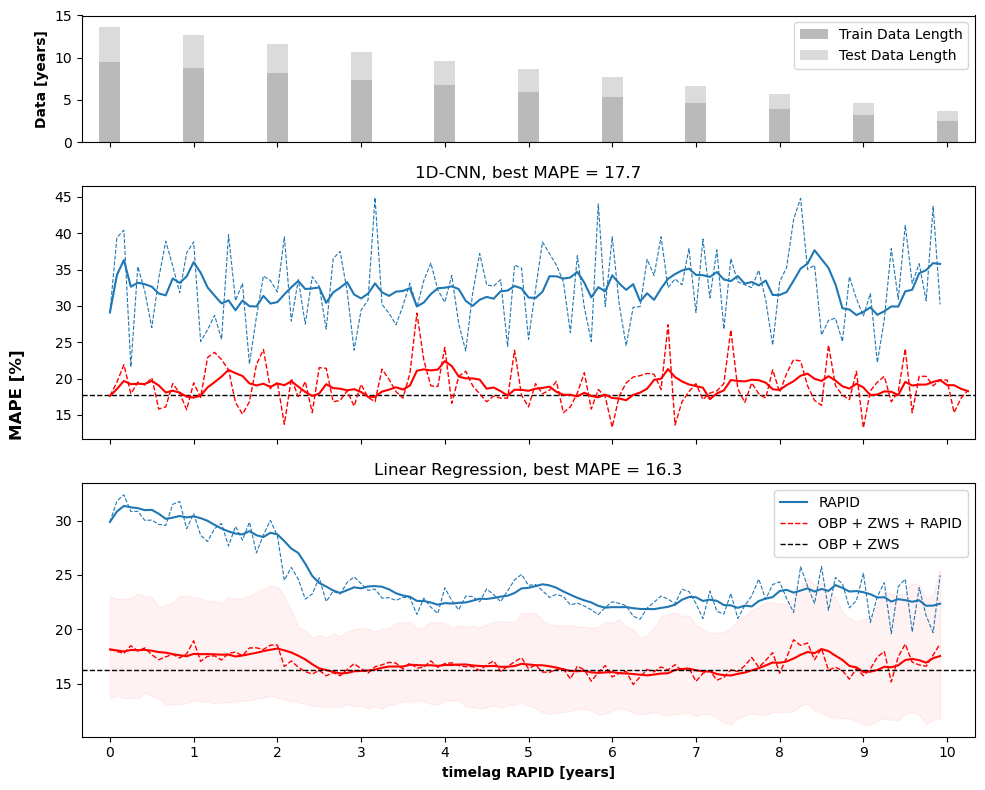

In [206]:
# Create a figure
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2], figure=fig)

# Creating subplots with different heights
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)

# First plot (shorter)
width = 3
ax0.bar(np.arange(timesteps)*12, train_info, alpha=0.8, width=width, color='darkgrey', label='Train Data Length')
ax0.bar(np.arange(timesteps)*12, test_info, alpha=0.8, width=width, label='Test Data Length', color='lightgrey', bottom=train_info)
ax0.set_ylabel('Data [years]', weight='bold')
ax0.set_yticks(np.arange(0, 200, 60))
ax0.set_yticklabels([f'{5*i}' for i in range(4)])
ax0.tick_params(labelbottom=False)
ax0.legend()

# Second plot
ax1.set_title(f"1D-CNN, best MAPE = {round(NN_mean_surf['mape'], 2)}")
ax1.plot(NN_mean_RAPID.index, NN_mean_RAPID['mape'], linestyle='--', color='tab:blue', linewidth=0.8)
ax1.plot(NN_mean_RAPID.index, NN_rolling_mean_RAPID, color='tab:blue', label='RAPID')
ax1.axhline(y=NN_mean_surf['mape'], color='black', linestyle='--', label='result surface variables', linewidth=1.0)
ax1.plot(NN_mean_combo.index, NN_mean_combo['mape'], linestyle='--', color='red', linewidth=1.0, label='RAPID + surface')
ax1.plot(NN_mean_combo.index, NN_rolling_mean_combo, color='red')
ax1.tick_params(labelbottom=False)

# Third plot
ax2.set_title(f"Linear Regression, best MAPE = {round(mean_surf['MAPE'], 1)}")
ax2.plot(mean_RAPID.index, mean_RAPID['MAPE'], linestyle='--', color='tab:blue', linewidth=0.8)
ax2.plot(mean_RAPID.index, trend_RAPID, color='tab:blue', label='RAPID')
ax2.plot(mean_combo.index, mean_combo['MAPE'], linestyle='--', color='red', linewidth=1.0, label='OBP + ZWS + RAPID')
ax2.plot(mean_combo.index, trend_combo, color='red')
ax2.fill_between(mean_combo.index, _05_combo, _095_combo, color='red', alpha=0.05)
ax2.axhline(y=mean_surf['MAPE'], color='black', linestyle='--', label='OBP + ZWS', linewidth=1.0)
ax2.legend()

plt.xticks(np.arange(0, 122, 12), labels=[f'{i}' for i in range(11)])
plt.xlabel('timelag RAPID [years]', weight="bold")
fig.supylabel('MAPE [%]', weight="bold")
plt.xlim([-4, 124])
plt.tight_layout()
plt.savefig(f"C:/Users/aline/OTP/plots/timelagRAPID_100folds.png", dpi=400)
plt.show()